In [1]:
library("tidyverse")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data preparation (archived)

In [47]:
LD_block = read_delim("/home/ubuntu/data/resource/ADSP_R4_EUR_LD/ld_meta_file.tsv")

Rows: 1361 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #chrom, path
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [49]:
max(LD_block$end)

[1] 248945661

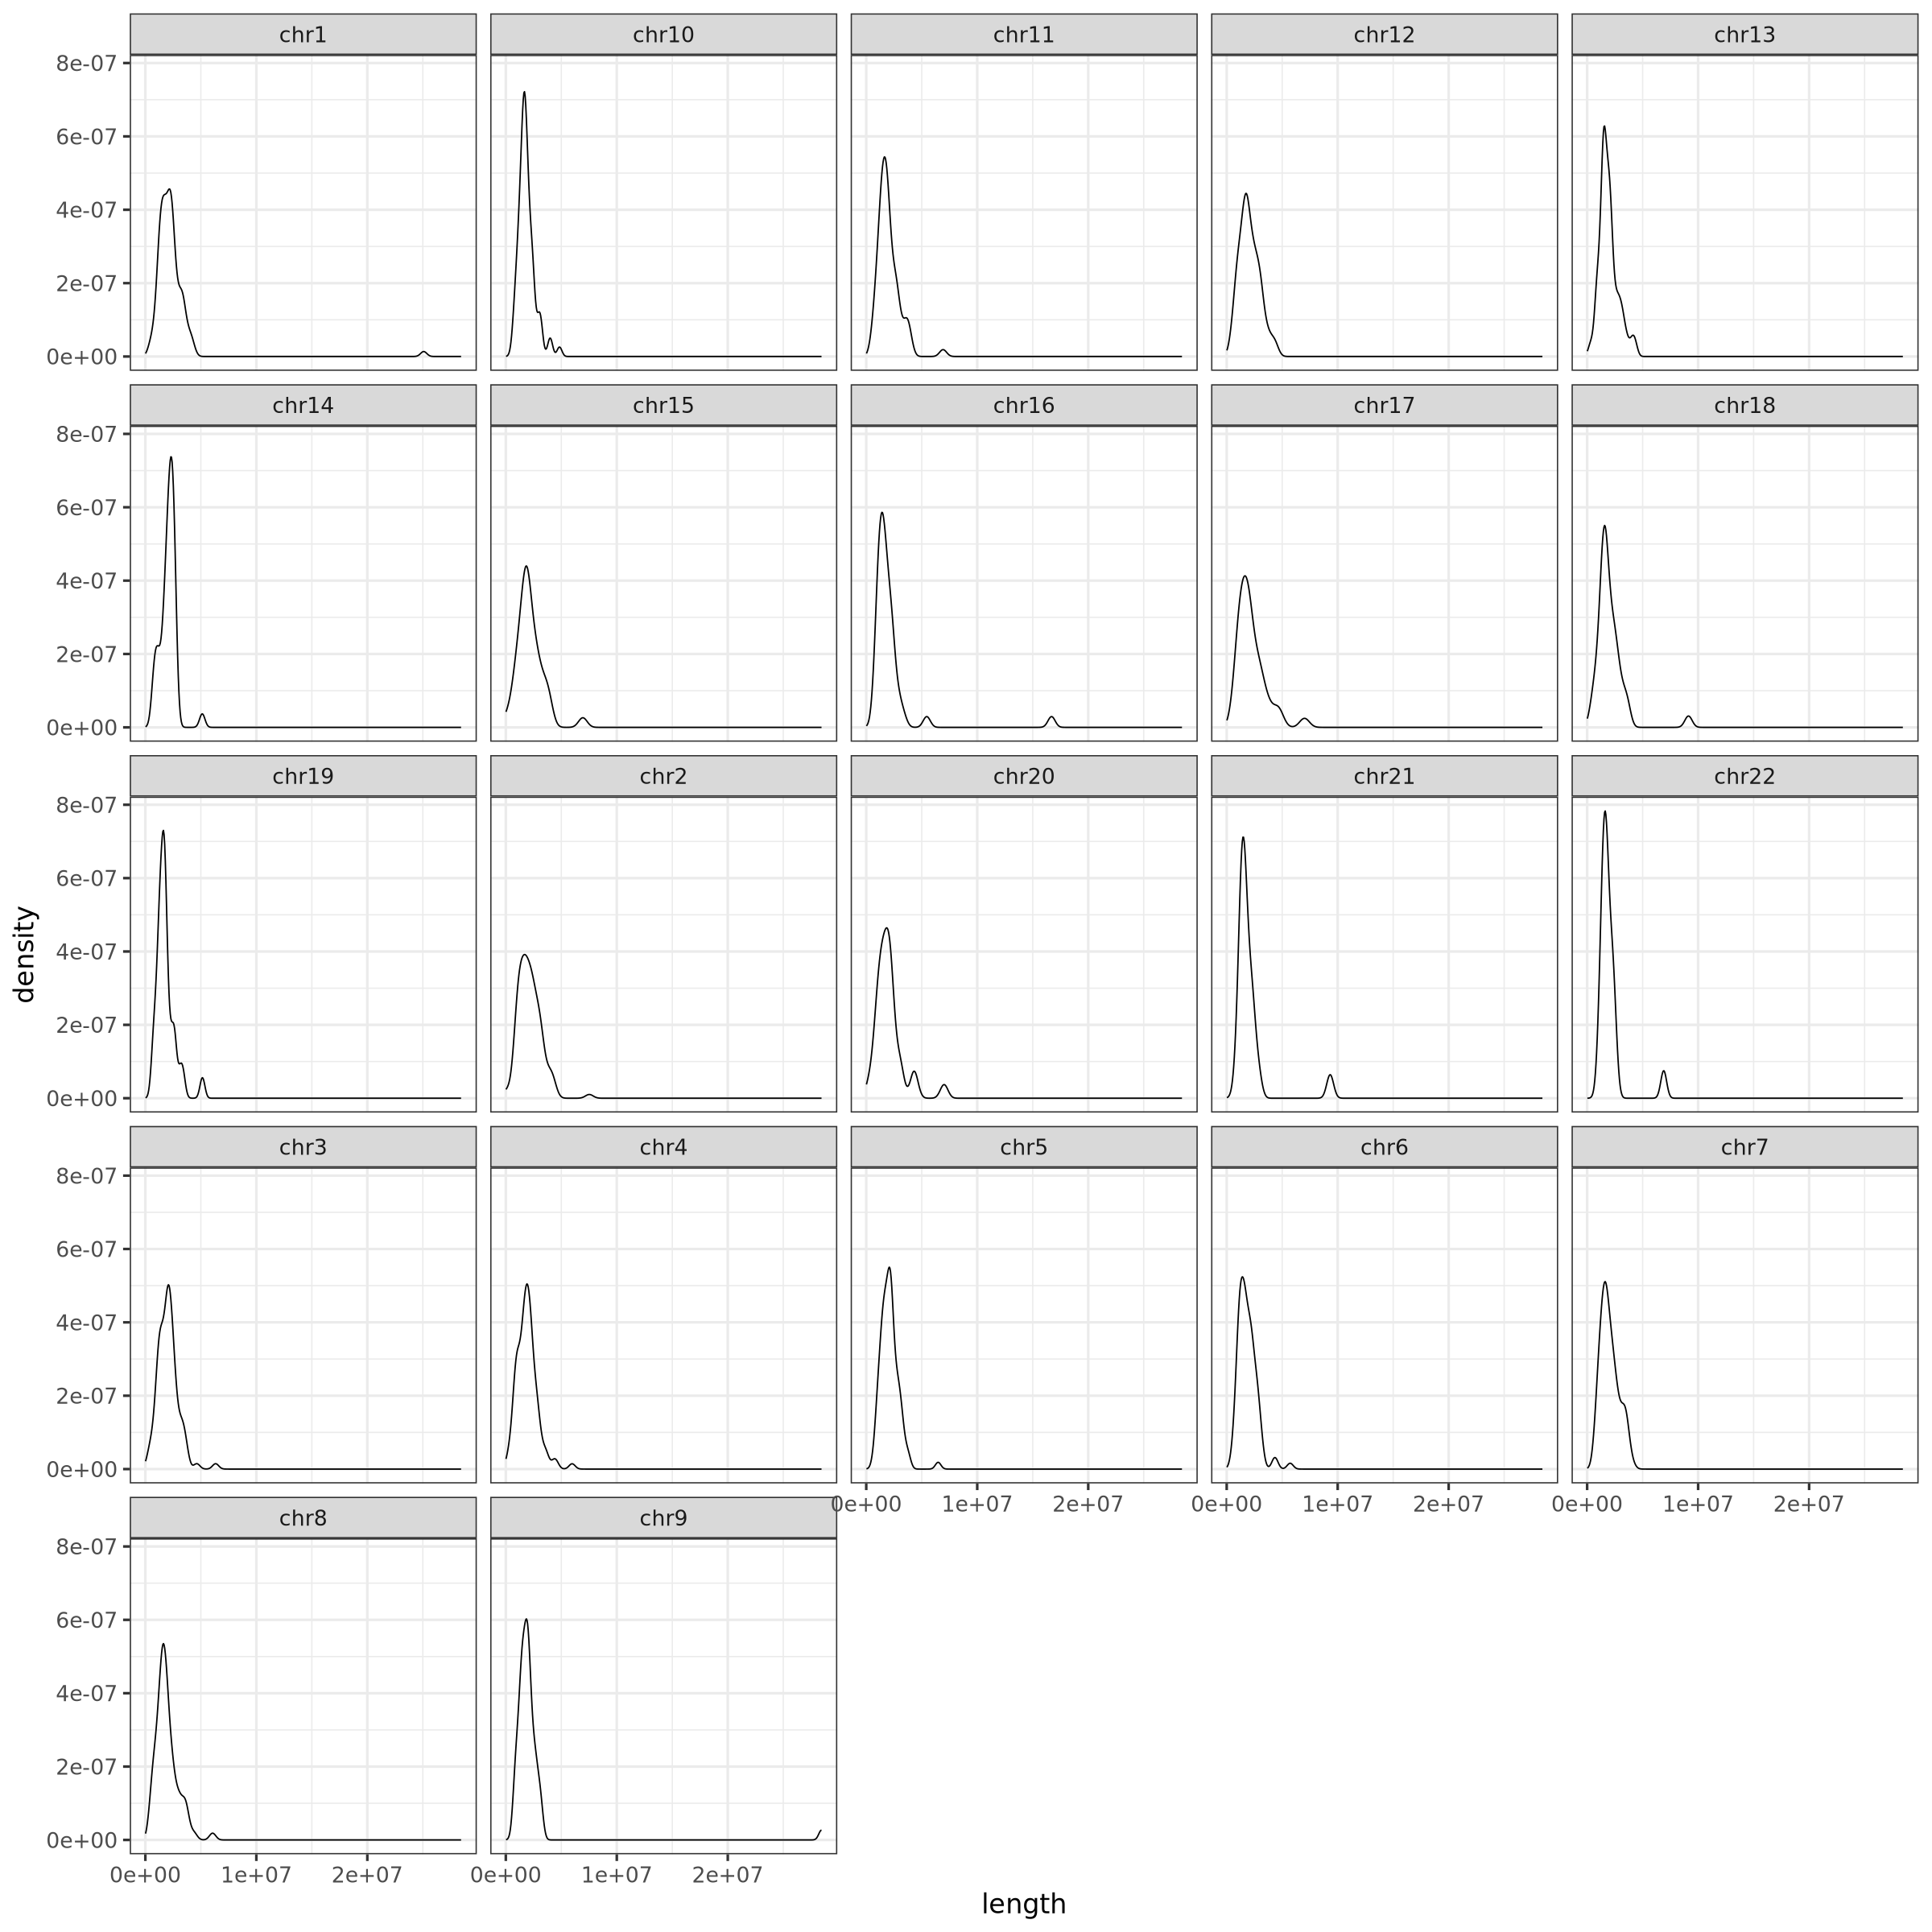

In [21]:
options(repr.plot.width = 20, repr.plot.height = 20)

LD_block%>%mutate(length = end - start)%>%ggplot()+geom_density(aes(x = length))+  theme_bw(base_size = 20)+facet_wrap(`#chrom`~.)

In [1]:
library(pecotmr)

Registered S3 methods overwritten by 'readr':
  method                    from 
  as.data.frame.spec_tbl_df vroom
  as_tibble.spec_tbl_df     vroom
  format.col_spec           vroom
  print.col_spec            vroom
  print.collector           vroom
  print.date_names          vroom
  print.locale              vroom
  str.col_spec              vroom

Warning message:
“replacing previous import ‘vroom::cols’ by ‘readr::cols’ when loading ‘pecotmr’”


In [50]:
load_LD_matrix

function (LD_meta_file_path, region, extract_coordinates = NULL) 
{
    intersected_LD_files <- get_regional_ld_meta(LD_meta_file_path, 
        region)
    LD_file_paths <- intersected_LD_files$intersections$LD_file_paths
    bim_file_paths <- intersected_LD_files$intersections$bim_file_paths
    extracted_LD_matrices_list <- list()
    extracted_LD_variants_list <- list()
    block_chroms <- character(length(LD_file_paths))
    for (j in seq_along(LD_file_paths)) {
        LD_matrix_processed <- process_LD_matrix(LD_file_paths[j], 
            bim_file_paths[j])
        extracted_LD_list <- extract_LD_for_region(LD_matrix = LD_matrix_processed$LD_matrix, 
            variants = LD_matrix_processed$LD_variants, region = intersected_LD_files$region, 
            extract_coordinates = extract_coordinates)
        extracted_LD_matrices_list[[j]] <- extracted_LD_list$extracted_LD_matrix
        extracted_LD_variants_list[[j]] <- extracted_LD_list$extracted_LD_variants
        if (nrow(extracted_LD_variants_list[[j]]) > 0) {
            block_chroms[j] <- as.character(extracted_LD_variants_list[[j]]$chrom[1])
        }
        else {
            block_chroms[j] <- as.character(intersected_LD_files$region$chrom)
        }
    }
    combined_LD_matrix <- create_combined_LD_matrix(LD_matrices = extracted_LD_matrices_list, 
        variants = extracted_LD_variants_list)
    combined_LD_variants <- rownames(combined_LD_matrix)
    block_variants <- lapply(extracted_LD_variants_list, function(v) v$variants)
    block_metadata <- data.frame(block_id = seq_along(LD_file_paths), 
        chrom = block_chroms, size = sapply(block_variants, length), 
        start_idx = sapply(block_variants, function(v) min(match(v, 
            combined_LD_variants))), end_idx = sapply(block_variants, 
            function(v) max(match(v, combined_LD_variants))), 
        stringsAsFactors = FALSE)
    rm(extracted_LD_matrices_list)
    ref_panel <- do.call(rbind, lapply(strsplit(rownames(combined_LD_matrix), 
        ":"), function(x) {
        data.frame(chrom = x[1], pos = as.integer(x[2]), A2 = x[3], 
            A1 = x[4])
    }))
    merged_variant_list <- do.call(rbind, extracted_LD_variants_list)
    ref_panel$variant_id <- rownames(combined_LD_matrix)
    if ("variance" %in% colnames(merged_variant_list)) {
        ref_panel$variance <- merged_variant_list$variance[match(rownames(combined_LD_matrix), 
            merged_variant_list$variants)]
    }
    combined_LD_list <- list(combined_LD_variants = combined_LD_variants, 
        combined_LD_matrix = combined_LD_matrix, ref_panel = ref_panel, 
        block_metadata = block_metadata)
    return(combined_LD_list)
}
<bytecode: 0x559e787701b0>
<environment: namespace:pecotmr>

In [4]:
op_index = tibble(cor = system("realpath /home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr*/*.cor.xz", intern = T),
bim = system("realpath /home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr*/*.bim", intern = T) )

Warning message in FUN(X[[i]], ...):
“restarting interrupted promise evaluation”


In [5]:
chr = paste0("chr", 1:22,"_")


In [7]:
library(dplyr)
library(readr)

op_index <- op_index %>% mutate(id = row_number())

bash_lines <- op_index %>%
  mutate(
    out = sprintf("density_%03d.txt", id),
    cmd = sprintf(
      "Rscript compute_density.R %s %s %s",
      shQuote(cor),
      shQuote(bim),
      shQuote(out)
    )
  ) %>%
  pull(cmd)

write_lines(bash_lines, "run_density.sh")


In [ ]:
result = op_index%>%mutate(density = map2( cor , bim , ~{

mat = pecotmr:::process_LD_matrix(.x,.y)
vals <- mat$LD_matrix[upper.tri(mat$LD_matrix, diag = FALSE)]
vals <- vals[!is.na(vals)]
dist = density(vals, from = -1, to = 1, n = 1024)
dens_df_chr <- tibble(cor = dist$x, density = dist$y, n = length(vals))
return(dens_df_chr)    
}  )

In [40]:
mat = pecotmr:::process_LD_matrix("/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr9/chr9_5557422_7758677.cor.xz","/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr9/chr9_5557422_7758677.cor.xz.bim")

In [55]:
mat = pecotmr:::process_LD_matrix("/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr9/chr9_5557422_7758677.cor.xz","/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr9/chr9_5557422_7758677.cor.xz.bim")
vals <- mat$LD_matrix[upper.tri(mat$LD_matrix, diag = FALSE)]
dist = density(vals, from = -1, to = 1, n = 1024)


In [ ]:
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)

## 1. Per-region density (list-column)

result <- op_index %>%
  mutate(
    density = map2(cor, bim, ~{
      mat  <- pecotmr:::process_LD_matrix(.x, .y)
      vals <- mat$LD_matrix[upper.tri(mat$LD_matrix, diag = FALSE)]
      vals <- vals[!is.na(vals)]
      dist <- density(vals, from = -1, to = 1, n = 1024)
      tibble(
        x = dist$x,      # correlation grid
        f = dist$y,      # density at x
        n = length(vals) # number of correlations in this region
      )
    })
  )



In [60]:
## 2. Combine to per-chromosome density (sample-size weighted)

per_chr_density <- result %>%
  unnest(density) %>%              # columns: chr, x, f, n
  group_by(chr, x) %>%
  summarise(
    f     = sum(f * n) / sum(n),   # weighted average
    n_tot = sum(n),
    .groups = "drop"
  )

## 3. (Optional) Global density across all chromosomes

global_density <- per_chr_density %>%
  group_by(x) %>%
  summarise(
    f     = sum(f * n_tot) / sum(n_tot),
    n_tot = sum(n_tot),
    .groups = "drop"
  )

## 4. Examples of use

# per-chr
ggplot(per_chr_density, aes(x, f)) +
  geom_line() +
  facet_wrap(~ chr, scales = "free_y")

# global
ggplot(global_density, aes(x, f)) +
  geom_line()

## 5. (Optional) save for later
saveRDS(per_chr_density, "LD_per_chr_density.rds")
saveRDS(global_density, "LD_global_density.rds")


In [ ]:
per_chr_density

In [62]:
length(vals) * 8 / 1024^3


[1] 0.554245

In [64]:
dist = density(vals, from = -1, to = 1, n = 2048)

In [69]:
object.size(dens_df_chr)

33616 bytes

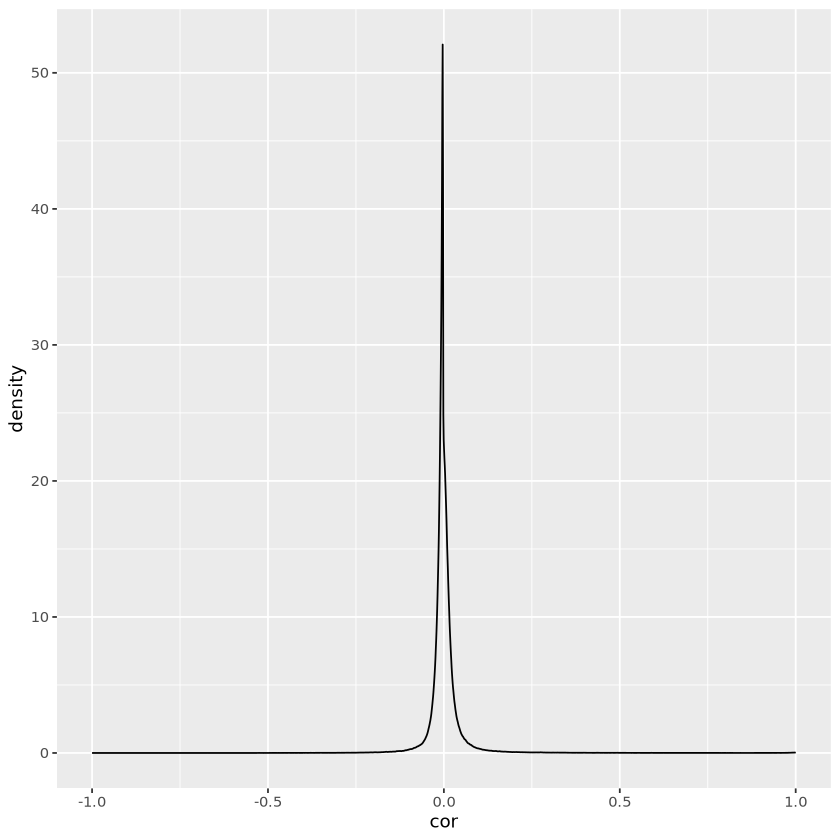

In [66]:
dens_df_chr <- data.frame(cor = dist$x, density = dist$y)

ggplot(dens_df_chr, aes(x = cor, y = density)) +
  geom_line()


In [63]:
format(object.size(vals), units = "MB")
format(object.size(vals), units = "GB")


[1] "567.5 Mb"

[1] "0.6 Gb"

In [25]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [27]:
op_index

cor,bim
<chr>,<chr>
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_101384274_104443097.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_101384274_104443097.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_104443097_106225286.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_104443097_106225286.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_106225286_109761915.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_106225286_109761915.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_109761915_111483530.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_109761915_111483530.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_111483530_113276642.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_111483530_113276642.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_113276642_115338054.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_113276642_115338054.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_11328222_12710318.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_11328222_12710318.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_115338054_117562321.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_115338054_117562321.cor.xz.bim
/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_117562321_119804207.cor.xz,/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr1/chr1_117562321_119804207.cor.xz.bim


In [11]:
out = scan(xzfile("/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr22/chr22_10516173_17414263.cor.xz"))

In [12]:
close(xzfile("/home/ubuntu/data/resource/ADSP_R4_EUR_LD/chr22/chr22_10516173_17414263.cor.xz"))


In [8]:
combined_txt = read_delim("combined_txt","\t")

Rows: 1393664 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): cor_file, bim_file
dbl (3): cor, density, n

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
library(dplyr)
library(stringr)

per_chr_density <- combined_txt %>%          # replace 'result' with your data frame name
  mutate(chr = str_extract(cor_file, "chr[0-9XY]+")) %>% 
  group_by(chr, cor) %>%
  summarise(
    density_chr = sum(density * n) / sum(n),  # weighted average
    n_tot       = sum(n),
    .groups     = "drop"
  )


In [61]:
per_chr_density%>%head

chr,cor,density_chr,n_tot,dens,density
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.0000000,0.002674344,5875430866,4.551742e-13,4.551742e-13
1,-0.9980450,0.006327673,5875430866,1.076972e-12,1.076972e-12
1,-0.9960899,0.006688947,5875430866,1.138461e-12,1.138461e-12
1,-0.9941349,0.005658318,5875430866,9.630472e-13,9.630472e-13
1,-0.9921799,0.004975255,5875430866,8.467898e-13,8.467898e-13
1,-0.9902248,0.004777540,5875430866,8.131387e-13,8.131387e-13


In [48]:
per_chr_density = per_chr_density%>%mutate(density = density_chr/n_tot)

In [56]:
 per_chr_density = per_chr_density%>%mutate(chr = str_remove(chr,"chr")%>%as.numeric)

Warning message in geom_line(point = 1):
“Ignoring unknown parameters: `point`”


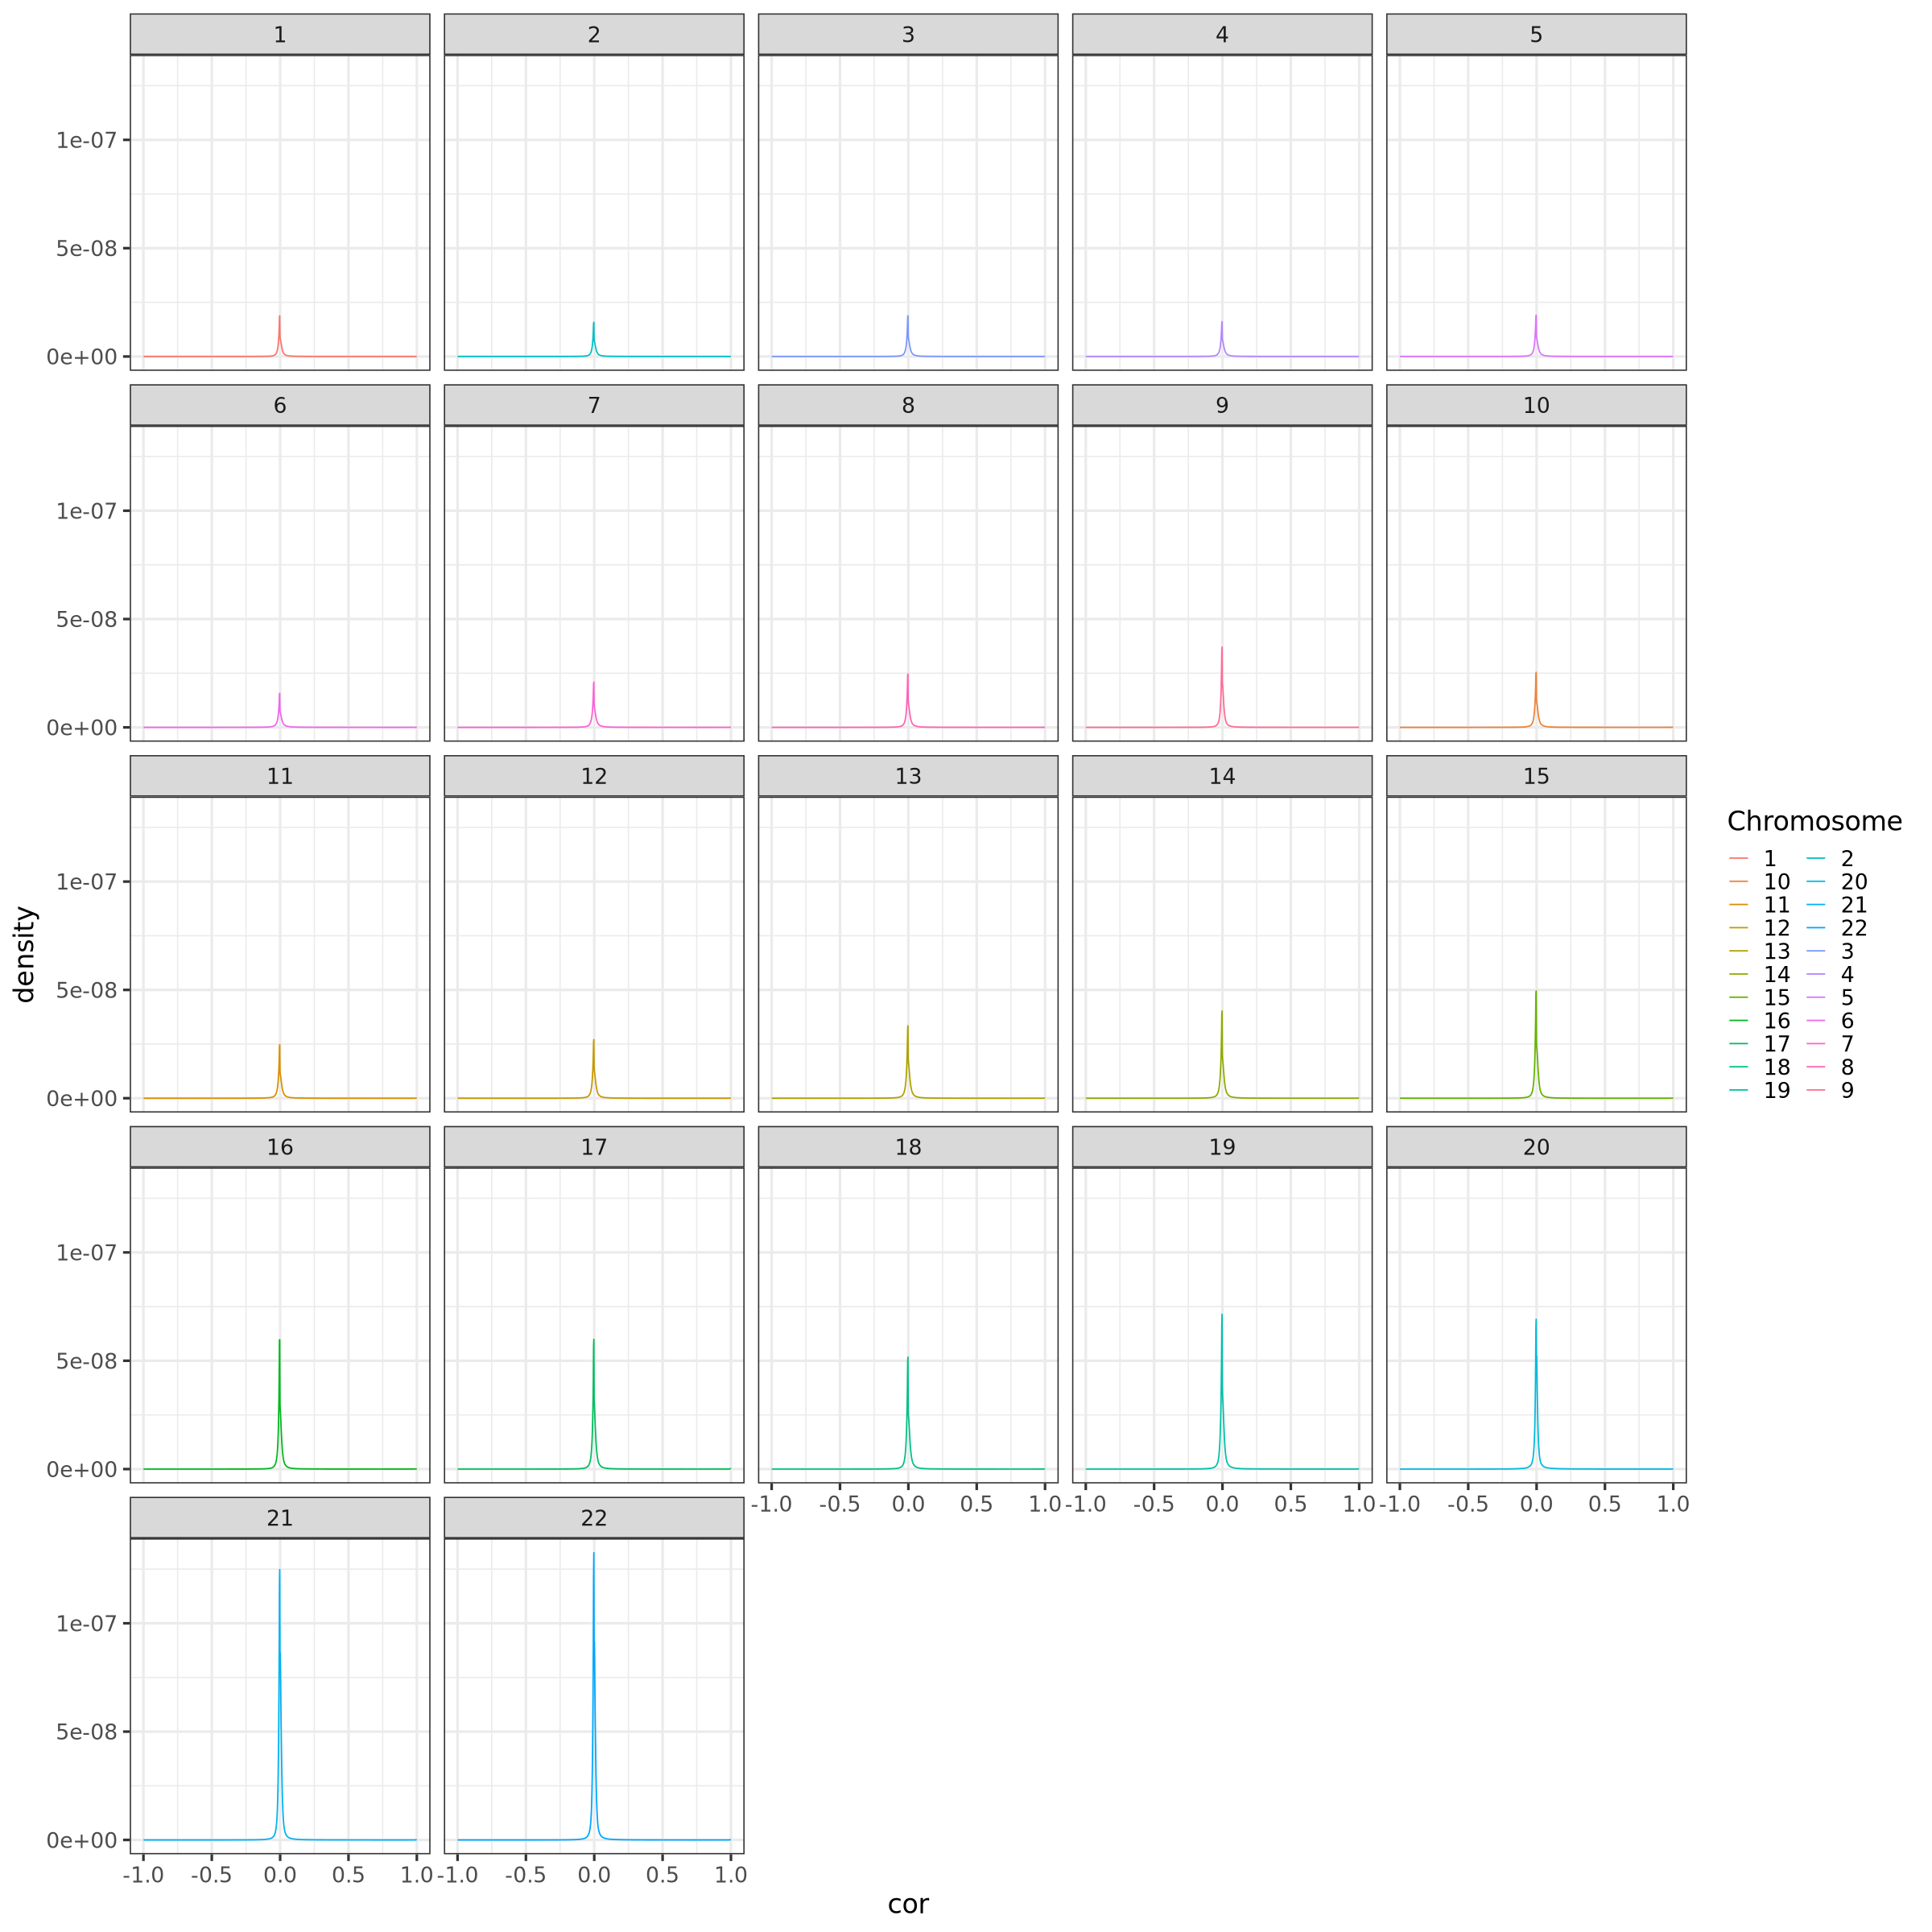

In [60]:
options(repr.plot.width = 20, repr.plot.height = 20)
per_chr_density%>%ggplot(aes(x = cor, y = density,color = as.character(chr))) +
  geom_line(point = 1)+  theme_bw(base_size = 20)+facet_wrap(`chr`~.)+
  labs(color = "Chromosome")

In [ ]:
per_chr_density%>%ggplot(aes(x = cor, y = density_chr,color = chr)) +
  geom_point()+  theme_bw(base_size = 20)+facet_wrap(`chr`~.)

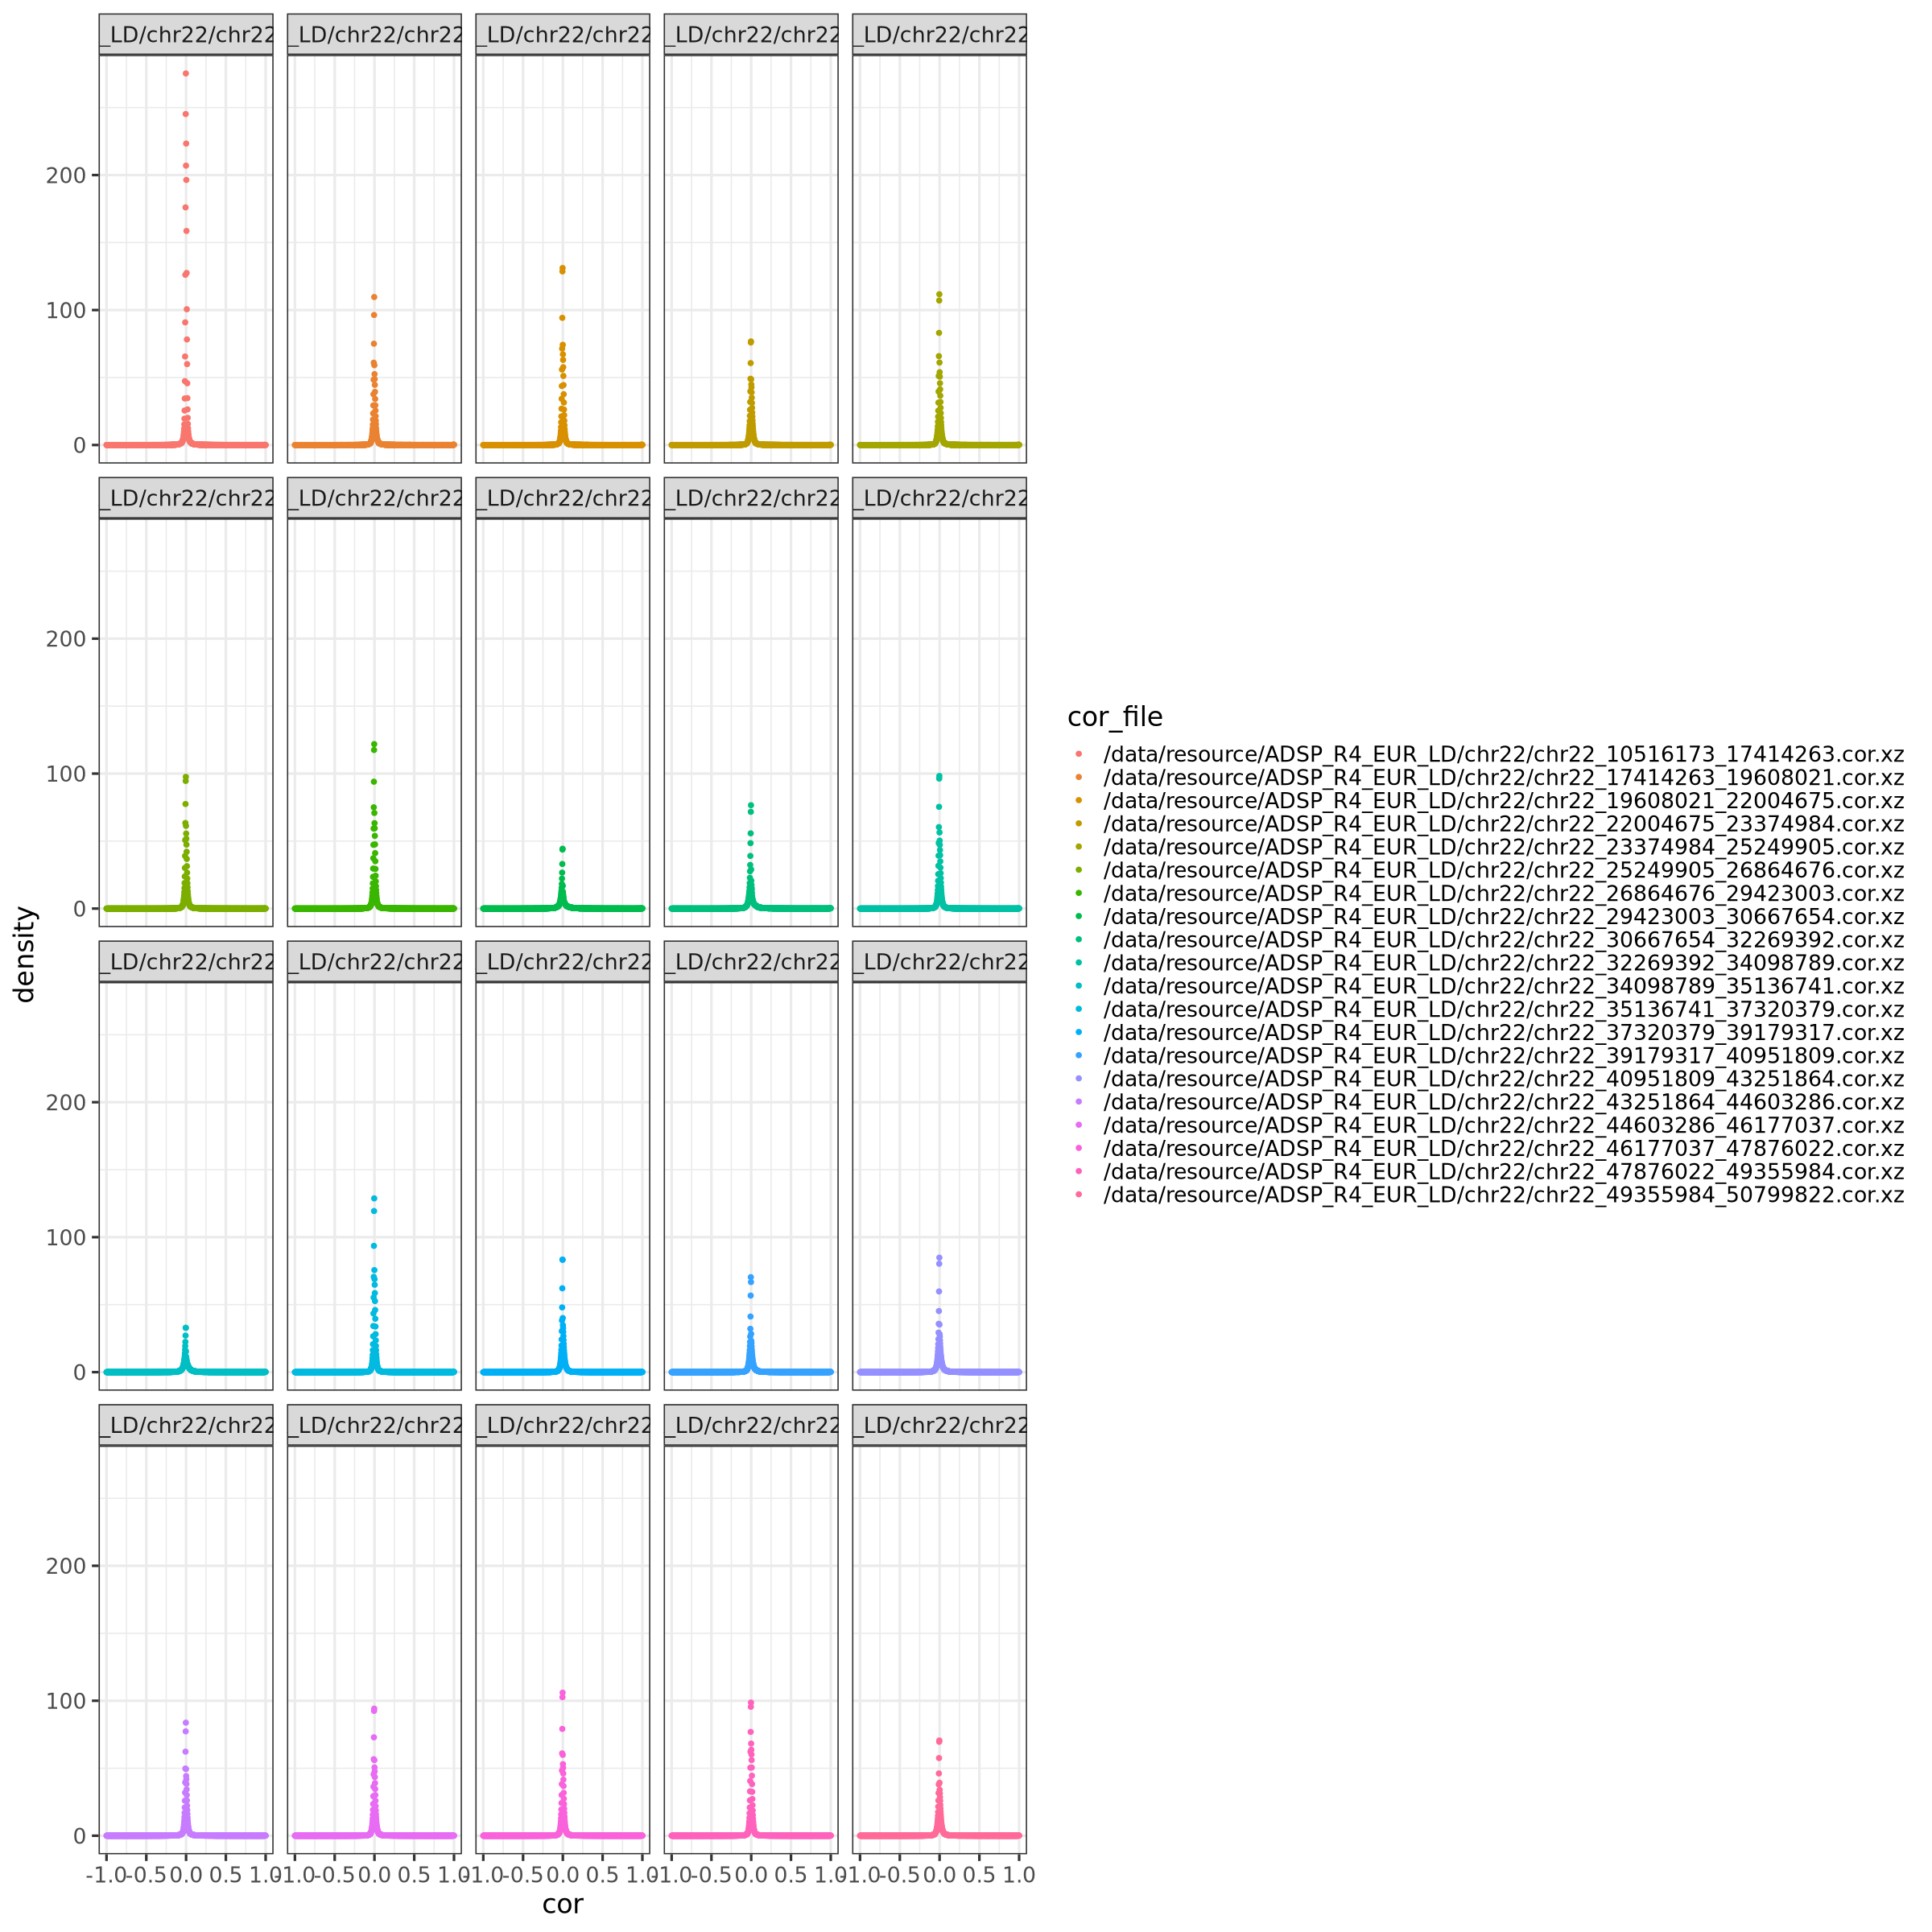

In [38]:
combined_txt%>%filter(str_detect(cor_file,"chr22_") )%>%ggplot(aes(x = cor, y = density,color = cor_file)) +
  geom_point()+  theme_bw(base_size = 20)+facet_wrap(cor_file~.)

In [13]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ purrr     1.1.0
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Generation of per chr plot

In [62]:
per_chr_density%>%saveRDS("figure_2D.rds")

In [ ]:
per_chr_density = readRDS("figure_2D.rds")

Warning message in geom_line(point = 1):
“Ignoring unknown parameters: `point`”


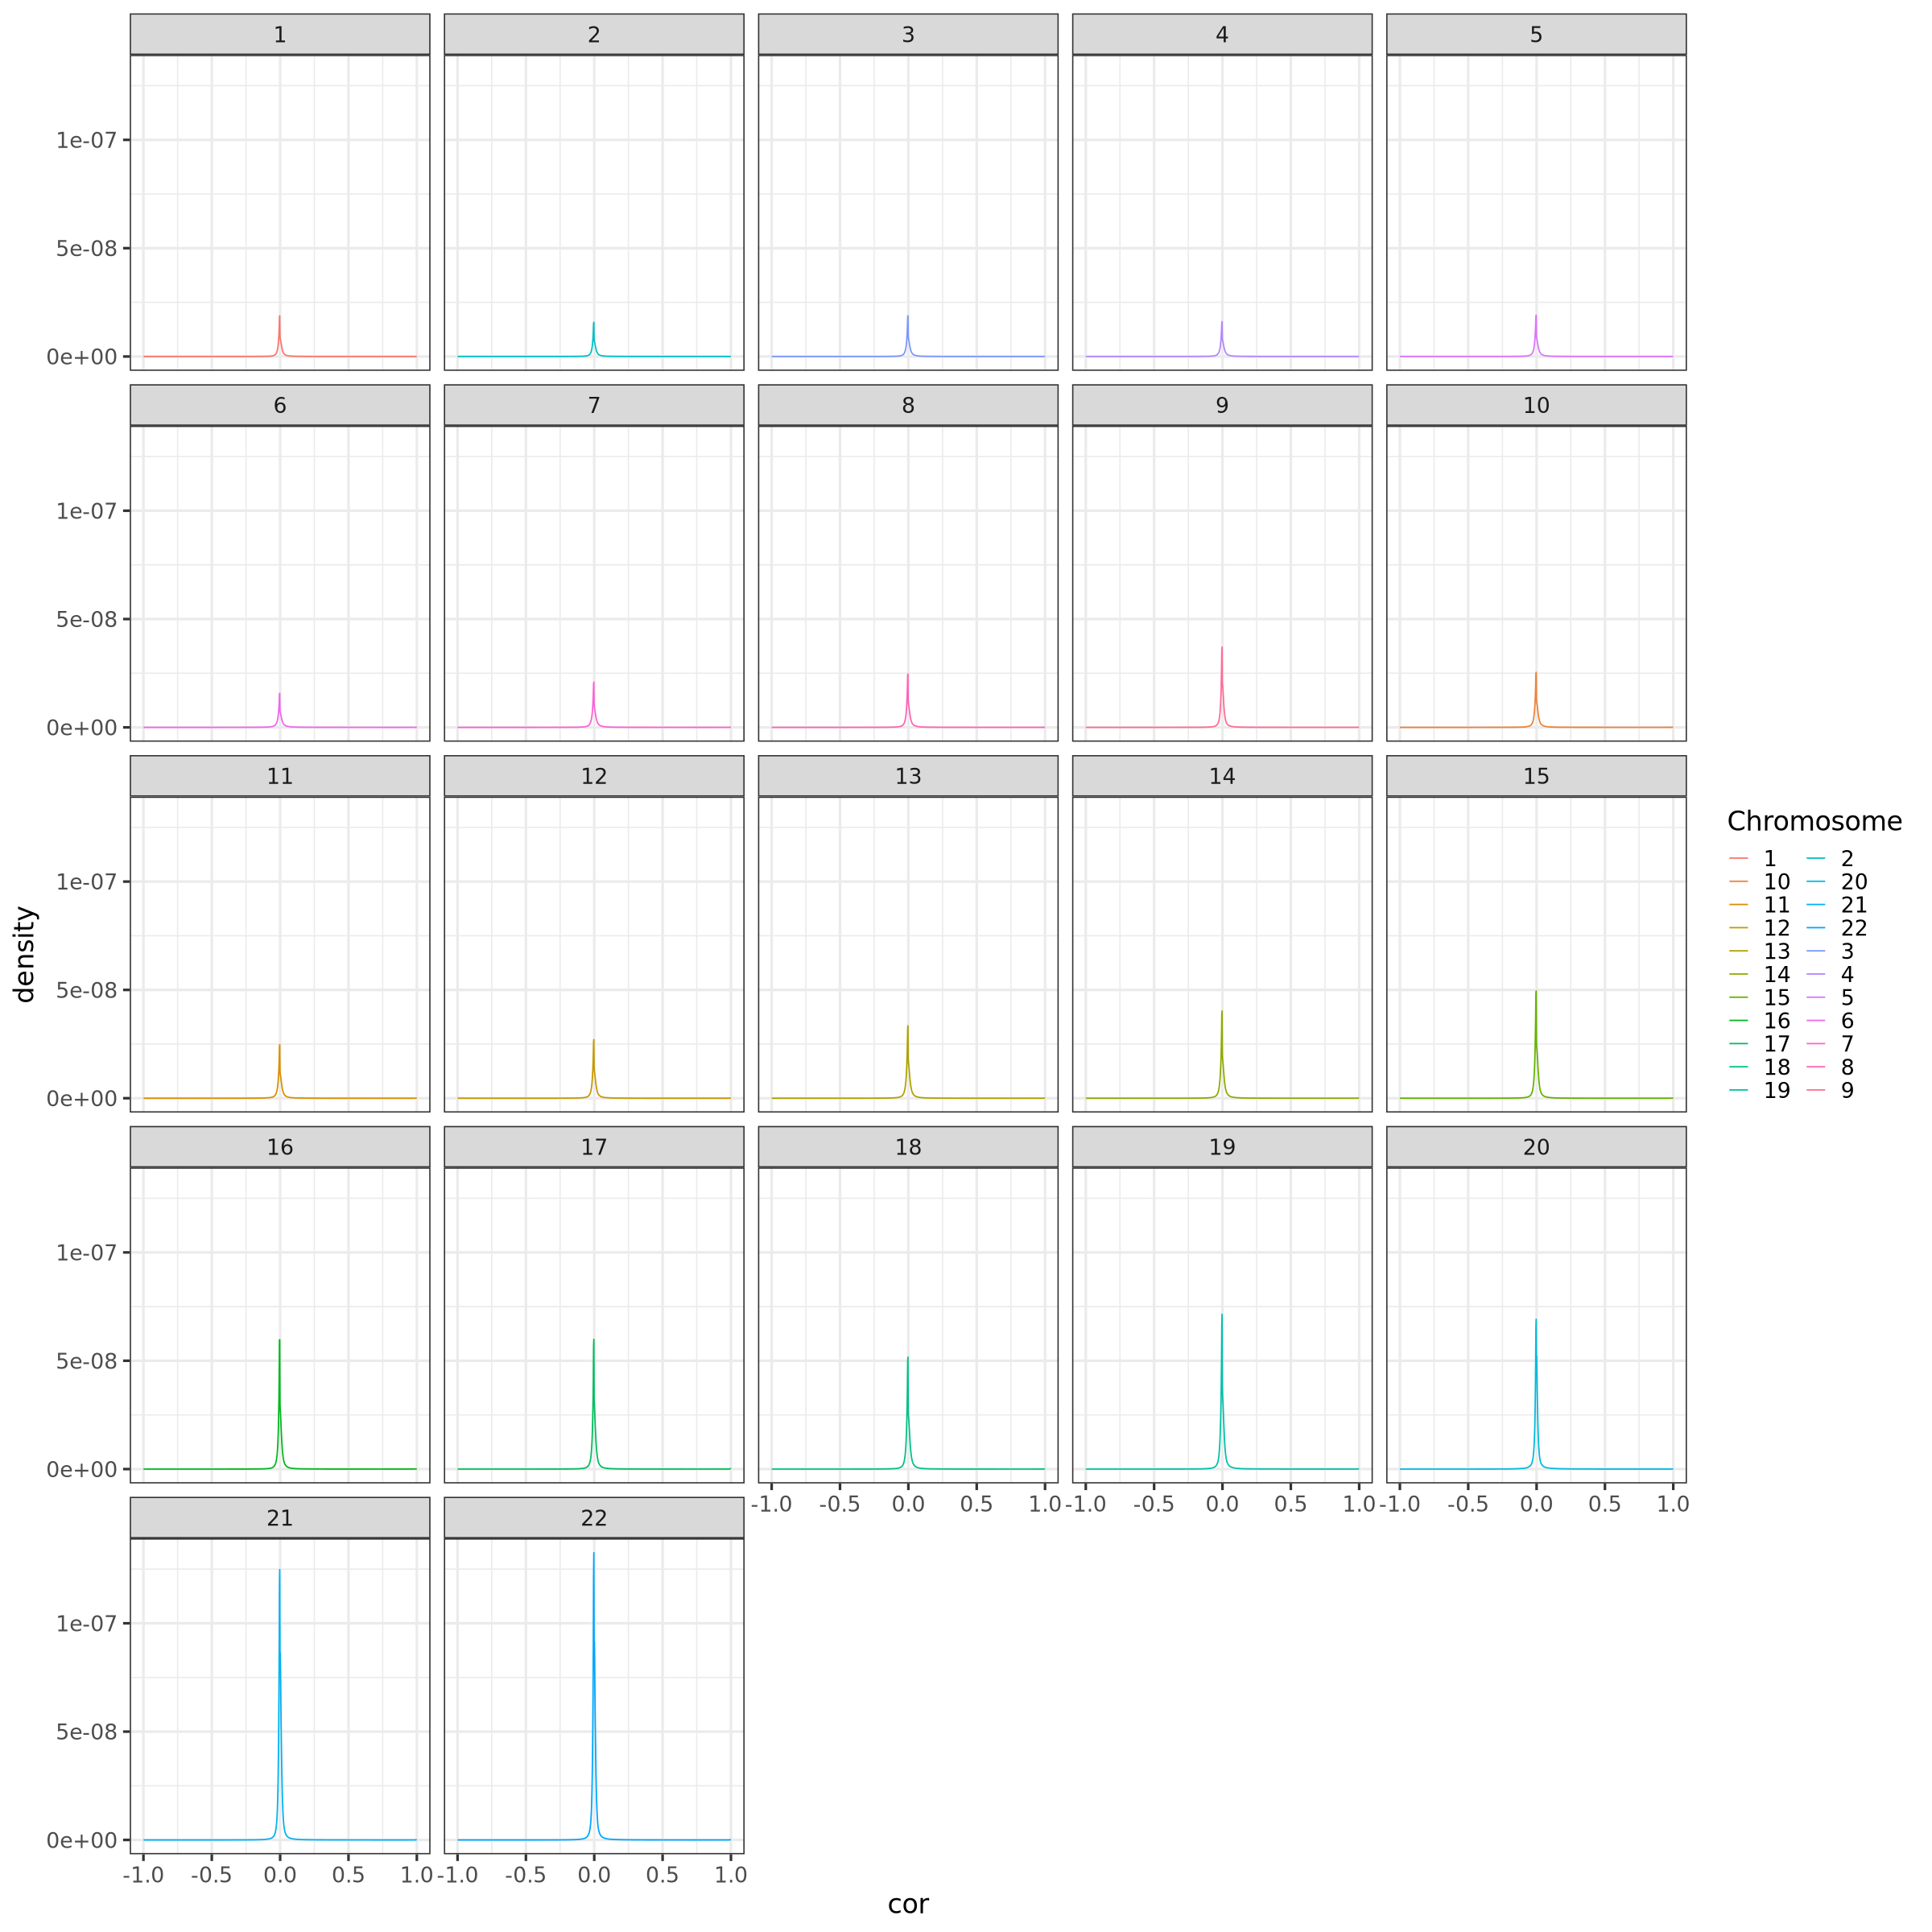

In [63]:
options(repr.plot.width = 20, repr.plot.height = 20)
per_chr_density%>%ggplot(aes(x = cor, y = density,color = as.character(chr))) +
  geom_line(point = 1)+  theme_bw(base_size = 20)+facet_wrap(`chr`~.)+
  labs(color = "Chromosome")